# Traffic Route Optimization in a City Map

## 🚦 Traffic Route Optimization Using Dijkstra's Algorithm

This notebook simulates a **city road network with different traffic densities** and finds two optimal routes:

1. **Quickest Route** 🏎️ - Minimizes distance without considering traffic congestion.
2. **Eco-Friendly Route** 🌱 - Optimizes for lower traffic and fuel consumption.

### 📌 Features:
- **City grid simulation** with roads and traffic conditions.
- **Dijkstra’s algorithm** for pathfinding.
- **Visualization of traffic conditions and optimal paths**.
- **Emissions & fuel efficiency statistics** for eco-conscious routing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import heapq
from tabulate import tabulate
import osmnx as ox
import networkx as nx
import folium

## 🗺️ Creating the City Road Traffic Map
The function below generates a **city grid** with roads and assigns **random traffic densities**.

In [2]:
def create_road_traffic_map(size):
    """
    Create a city road map where roads have different traffic densities.
    """
    city_map = np.zeros((size, size), dtype=int)
    weights = np.full((size, size), float('inf'))  # Default all areas to non-traversable

    # Define colors for visualization
    traffic_colors = {
        "low": 3,    # Green roads (light traffic)
        "medium": 2, # Yellow roads (moderate traffic)
        "high": 1    # Red roads (heavy traffic)
    }

    # Add roads at regular intervals
    for i in range(1, size, 5):
        for j in range(size):
            city_map[i, j] = 4  # Horizontal roads
            weights[i, j] = random.choice([1.5, 3.0, 5.0])  # Assign random traffic density

    for j in range(1, size, 5):
        for i in range(size):
            city_map[i, j] = 4  # Vertical roads
            weights[i, j] = random.choice([1.5, 3.0, 5.0])  # Assign random traffic density

    # Update road colors based on traffic density
    for i in range(size):
        for j in range(size):
            if city_map[i, j] == 4:  # Road cells only
                traffic_weight = weights[i, j]
                if traffic_weight == 1.5:
                    city_map[i, j] = traffic_colors["low"]  # Green (low traffic)
                elif traffic_weight == 3.0:
                    city_map[i, j] = traffic_colors["medium"]  # Yellow (medium traffic)
                else:
                    city_map[i, j] = traffic_colors["high"]  # Red (high traffic)

    return city_map, weights


## 🖼️ Displaying the Traffic Map
This function **visualizes** the city roads, traffic densities, and highlights routes.

In [3]:
def display_traffic_map(city_map, path1=None, path2=None, start=None, end=None):
    """
    Display the traffic map with improved aesthetics, including start and end markers.
    """
    # Improved aesthetic colors
    cmap_colors = [
        "#f0f0f0",  # 0 - Unpassable (light gray)
        "#d9534f",  # 1 - High Traffic (red)
        "#f4a742",  # 2 - Medium Traffic (orange)
        "#3cb371",  # 3 - Low Traffic (green)
        "#1e1e1e",  # 4 - Roads (dark gray)
        "#007bff",  # 5 - Quickest Route (blue)
        "#17becf",  # 6 - Eco-Friendly Route (cyan)
        "#FF00FF",  # 7 - Start Location (Red Pin)
        "#8000FF"   # 8 - Destination (Green Pin)
    ]
    cmap = mcolors.ListedColormap(cmap_colors)

    plt.figure(figsize=(12, 10))
    plt.imshow(city_map, cmap=cmap, origin="upper", vmin=0, vmax=8)
    plt.title("Optimized Traffic Route Map", fontsize=14)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")

    # Add route paths
    if path1:
        for x, y in path1:
            city_map[y, x] = 5  # Quickest Route (blue)
    if path2:
        for x, y in path2:
            city_map[y, x] = 6  # Eco-Friendly Route (cyan)

    # **Add start and end markers**
    if start:
        city_map[start[1], start[0]] = 7  # Start marker (Red Pin)
    if end:
        city_map[end[1], end[0]] = 8  # End marker (Green Pin)

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='#f0f0f0', lw=4, label="Unpassable Area"),
        plt.Line2D([0], [0], color='#d9534f', lw=4, label="High Traffic"),
        plt.Line2D([0], [0], color='#f4a742', lw=4, label="Medium Traffic"),
        plt.Line2D([0], [0], color='#3cb371', lw=4, label="Low Traffic"),
        plt.Line2D([0], [0], color='#1e1e1e', lw=4, label="Roads"),
        plt.Line2D([0], [0], color='#007bff', lw=4, label="Quickest Route"),
        plt.Line2D([0], [0], color='#17becf', lw=4, label="Most Eco-Friendly Route"),
        plt.Line2D([0], [0], color='#ff00ff', lw=8, label="Start Location"),
        plt.Line2D([0], [0], color='#8000FF', lw=8, label="Destination")
    ]
    plt.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.05, 0.5))
    
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


## 🚗 Finding the Best Routes Using Djikstra's Algorithm
The function below finds:
- **Quickest Route** using shortest distance.
- **Eco-Friendly Route** minimizing fuel consumption.


In [4]:
def dijkstra(city_map, weights, start, end, optimize_traffic=True):
    """
    Run Dijkstra’s algorithm for shortest or eco-friendly path finding.
    """
    rows, cols = city_map.shape
    costs = {start: 0}  
    priority_queue = [(0, start)]  
    parent = {start: None}  

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  

    while priority_queue:
        current_cost, current_cell = heapq.heappop(priority_queue)

        if current_cell == end:
            path = []
            while current_cell:
                path.append(current_cell)
                current_cell = parent[current_cell]
            return path[::-1]  

        for dx, dy in directions:
            neighbor = (current_cell[0] + dx, current_cell[1] + dy)
            x, y = neighbor

            if 0 <= x < rows and 0 <= y < cols and city_map[y, x] in [1, 2, 3, 4]:
                new_cost = current_cost + (weights[y, x] if optimize_traffic else 1.0)

                if neighbor not in costs or new_cost < costs[neighbor]:
                    costs[neighbor] = new_cost
                    parent[neighbor] = current_cell
                    heapq.heappush(priority_queue, (new_cost, neighbor))

    return None


# Helper functions
The functions below help with the following:
- **highlight_routes** overlays 2 given paths/routes on the city map.
- **find_nearest_road** uses BFS to find the nearest road to a given x, y coordinate.
- **calculate_path_statistics** calculates the CO2 emissions, and other statistics of the route provided.

In [5]:
def start_end_markers(city_map, start, end):
    """
    Mark the start and end points on the city map.
    """
    city_map_with_markers = np.copy(city_map)
    city_map_with_markers[start[1], start[0]] = 7  # Start marker
    city_map_with_markers[end[1], end[0]] = 8  # End marker

    return city_map_with_markers

def highlight_routes(city_map, path1, path2):
    """
    Overlay both paths on the city map with proper labeling.
    """
    city_map_highlighted = np.copy(city_map)

    # Quickest route (Blue)
    for x, y in path1:
        city_map_highlighted[y, x] = 5

    # Most Eco-Friendly route (Cyan)
    for x, y in path2:
        city_map_highlighted[y, x] = 6

    city_map_highlighted = start_end_markers(city_map_highlighted, path1[0], path1[-1])
    display_traffic_map(city_map_highlighted)

def find_nearest_road(city_map, x, y):
    """
    Finds the nearest road from the given (x, y) coordinate using BFS.
    Roads are marked with values [1, 2, 3, 4].
    """
    size = city_map.shape[0]
    queue = [(x, y, 0)]  # (x, y, distance)
    visited = set()
    
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    
    while queue:
        cx, cy, dist = queue.pop(0)
        
        # If the cell is a road, return its coordinates
        if city_map[cy, cx] in [1, 2, 3, 4]:
            return (cx, cy)
        
        visited.add((cx, cy))
        
        # Explore neighbors
        for dx, dy in directions:
            nx, ny = cx + dx, cy + dy
            if 0 <= nx < size and 0 <= ny < size and (nx, ny) not in visited:
                queue.append((nx, ny, dist + 1))
    
    return (x, y)  # If no road is found (edge case), return original position

def calculate_path_statistics(city_map, path):
    """
    Calculate total distance and estimated emissions based on the path taken.
    """
    if not path:
        return float('inf'), float('inf')  # No valid path found

    total_distance = len(path)  # Each step = 1 unit of distance
    total_fuel = 0  

    # Traffic-based fuel consumption
    fuel_consumption = {
        1: 2.5,  # High Traffic (Red)
        2: 1.5,  # Medium Traffic (Yellow)
        3: 1.0,  # Low Traffic (Green)
        4: 1.0   # Roads (Black)
    }

    for x, y in path:
        zone_type = city_map[y, x]
        total_fuel += fuel_consumption.get(zone_type, 1.0)  # Default to 1.0 if unknown

    total_emissions = total_fuel * 2  # 1 fuel unit = 2 kg CO₂ emissions
    return total_distance, total_emissions

## 🏁 Running the Simulation
Generates the **city traffic map**, gets **user inputs**, computes **optimal routes**, and **visualizes them**.


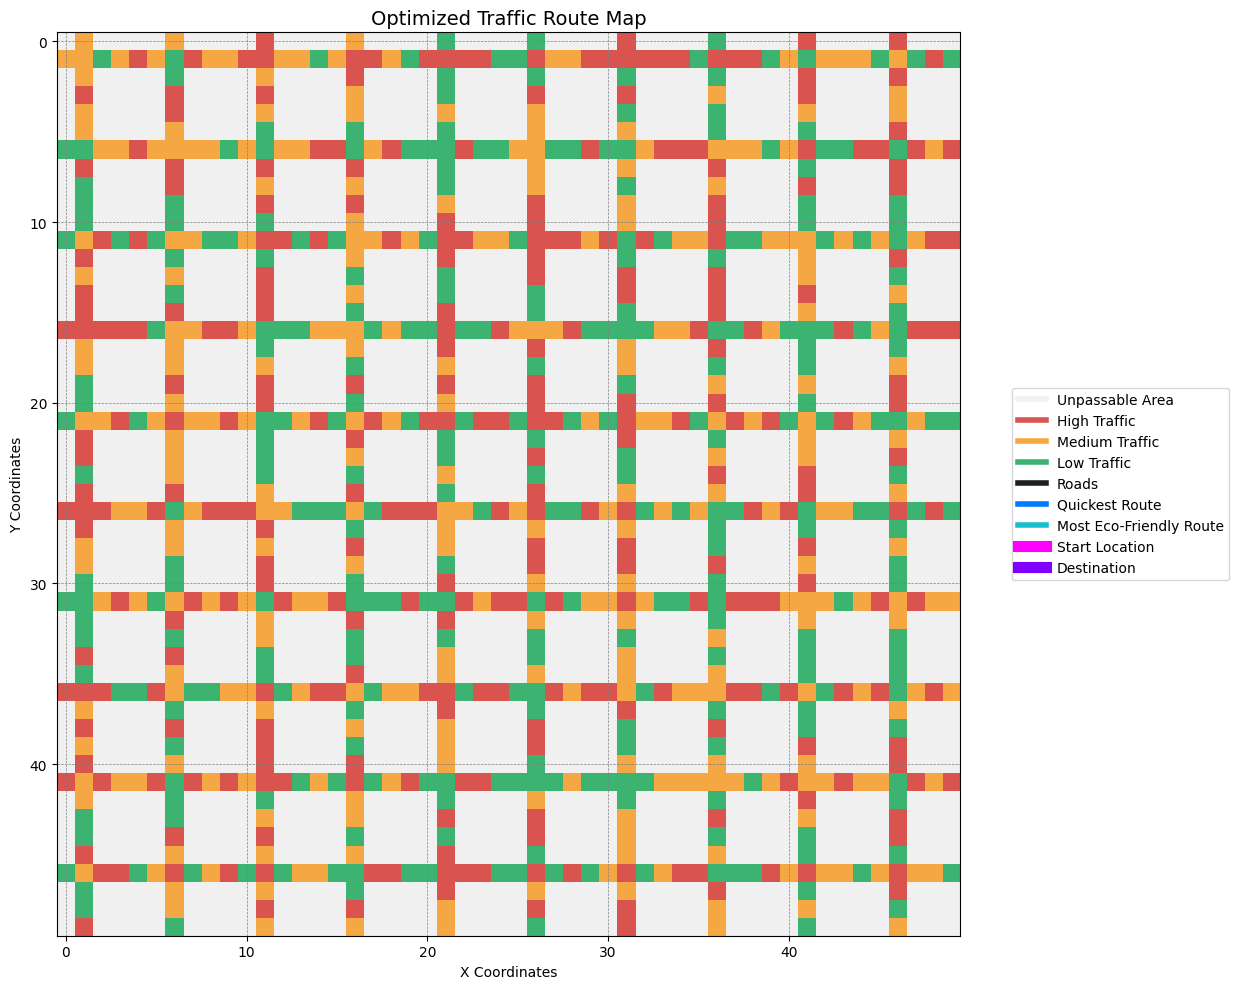

Enter Start Coordinates (0 to 49, 0 to 49):  5 40
Enter End Coordinates (0 to 49, 0 to 49):  45 15



Start adjusted to nearest road at: (6, 40)
End adjusted to nearest road at: (46, 15)

Finding Quickest Route...

Finding Most Eco-Friendly Route...

Both Quickest & Eco-Friendly Routes Found!


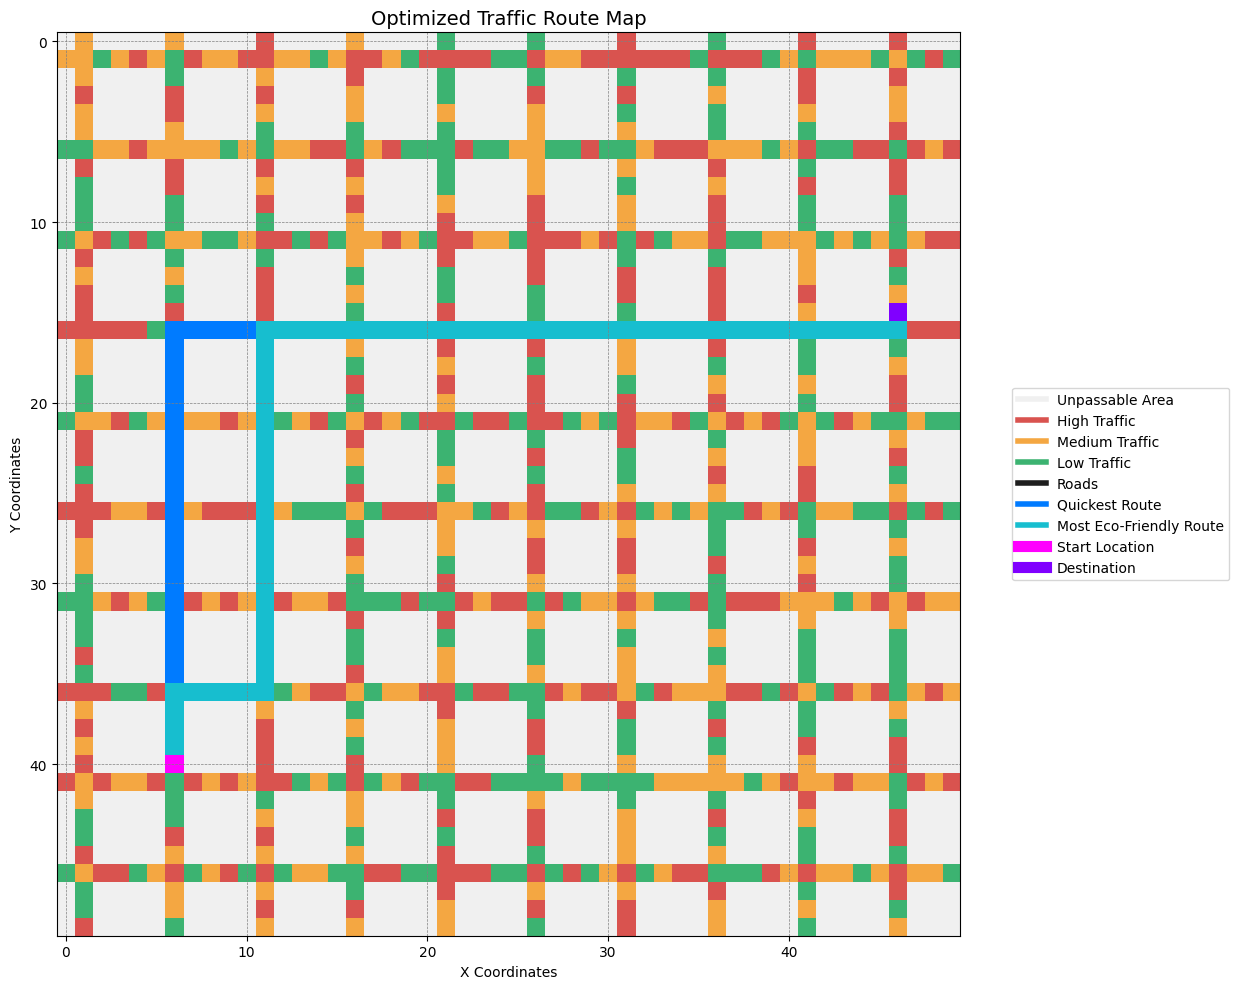


========== Route Summary ==========
+----------------------------+--------------------+---------------+
| Route Type                 |   Distance (units) | Emissions     |
+============================+====================+===============+
| 📏 Shortest Distance Route |                 66 | 200.00 kg CO₂ |
+----------------------------+--------------------+---------------+
| 🌱 Eco-Friendly Route      |                 66 | 192.00 kg CO₂ |
+----------------------------+--------------------+---------------+

✅ Choosing the Eco-Friendly Route reduces emissions by 4.00%! 🌍


In [6]:
size = 50
city_map, weights = create_road_traffic_map(size)
display_traffic_map(city_map)

try:
    # Get start and end coordinates from user
    x1, y1 = map(int, input(f"Enter Start Coordinates (0 to {size-1}, 0 to {size-1}): ").split())
    x2, y2 = map(int, input(f"Enter End Coordinates (0 to {size-1}, 0 to {size-1}): ").split())

    # Validate if the input is within bounds
    if all(0 <= coord < size for coord in [x1, y1, x2, y2]):
        # Snap start and end points to nearest roads
        start = find_nearest_road(city_map, x1, y1)
        end = find_nearest_road(city_map, x2, y2)

        print(f"\nStart adjusted to nearest road at: {start}")
        print(f"End adjusted to nearest road at: {end}")

        print("\nFinding Quickest Route...")
        quickest_path = dijkstra(city_map, weights, start, end, optimize_traffic=False)

        print("\nFinding Most Eco-Friendly Route...")
        eco_path = dijkstra(city_map, weights, start, end, optimize_traffic=True)

        # Ensure paths are valid before highlighting
        if quickest_path and eco_path:
            print("\nBoth Quickest & Eco-Friendly Routes Found!")
            highlight_routes(city_map, quickest_path, eco_path)

        elif quickest_path:
            print("\nOnly Quickest Route Found!")
            highlight_routes(city_map, quickest_path, [])

        elif eco_path:
            print("\nOnly Most Eco-Friendly Route Found!")
            highlight_routes(city_map, [], eco_path)

        else:
            print("\nNo possible route found between the selected points.")
            exit()

        # Compute and print statistics
        shortest_distance, shortest_emissions = calculate_path_statistics(city_map, quickest_path)
        eco_distance, eco_emissions = calculate_path_statistics(city_map, eco_path)

        # Prepare table data
        table_data = [
            ["📏 Shortest Distance Route", shortest_distance, f"{shortest_emissions:.2f} kg CO₂"],
            ["🌱 Eco-Friendly Route", eco_distance, f"{eco_emissions:.2f} kg CO₂"]
        ]
        headers = ["Route Type", "Distance (units)", "Emissions"]

        print("\n========== Route Summary ==========")
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

        # Calculate emission reduction percentage
        if shortest_emissions > eco_emissions:
            reduction = ((shortest_emissions - eco_emissions) / shortest_emissions) * 100
            print(f"\n✅ Choosing the Eco-Friendly Route reduces emissions by {reduction:.2f}%! 🌍")
        else:
            print("\n⚠️ No significant emissions reduction using the Eco-Friendly Route.")

    else:
        print("\nError: Coordinates are out of bounds!")

except ValueError:
    print("\nInvalid input! Please enter integer coordinates.")

# Pre-existing cities
## Taking a smart city, and finding pedestrian, bike and drive routes through the city

In [7]:
import osmnx as ox
import networkx as nx
import geopandas as gpd

def save_routes_for_request(selected_city = "Bangalore", origin_point = (12.9716, 77.5946), destination_point = (12.9352, 77.6146), mode = 'drive', isEcoFriendly = False):
    # Download the street network for the area encompassing both points
    G = ox.graph_from_point(origin_point, dist=3000, network_type=mode)
    
    if mode == 'walk':
        col = 'green'
    elif mode == 'bike':
        col = 'blue'
    else:
        col = 'red'

    # Find the nearest nodes to the origin and destination points
    orig_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0])
    dest_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0])

    if isEcoFriendly:
        # Use the eco-friendly route
        route = nx.shortest_path(G, orig_node, dest_node, weight='elevation_change')
    else:
        # Use the shortest path based on length
        route = nx.shortest_path(G, orig_node, dest_node, weight='length')

    # Convert the route to a GeoDataFrame
    route_gdf = ox.routing.route_to_gdf(G, route)

    # Visualize the route interactively
    m = route_gdf.explore(tiles='cartodbpositron', color=col, linewidth=5)
    m.save(f'route_map_{selected_city}_{mode}_ecofriendly_{isEcoFriendly}.html')
    
    # Calculate the total length of the route
    total_length = route_gdf['length'].sum()

    return total_length/1000 # Convert to kilometers


In [10]:
# Choose a smart city
smart_cities = ["Singapore", "Amsterdam, Netherlands", "Barcelona, Spain", "Dubai, UAE", "Tokyo, Japan", "Delhi", "Mumbai"]

print("\n🌍 Available Smart Cities:")
for i, city in enumerate(smart_cities, 1):
    print(f"{i}. {city}")

choice = int(input("\nEnter the number of the city you want to use: ")) - 1
selected_city = smart_cities[choice]

route_options = {
    1: {'name': 'Shortest Route', 'color': '#007bff'},
    2: {'name': 'Eco-Friendly Route', 'color': '#17becf'},
    3: {'name': 'Bicycle Route', 'color': '#FFA500'},
    4: {'name': 'Pedestrian Route', 'color': '#800080'}
}

print("\n🌍 Available Route Types:")
for num, option in route_options.items():
    print(f"{num}. {option['name']}")

selected = list(map(int, input("Enter route numbers to display (e.g., 1 3 4): ").split()))

# Get user input for coordinates
start_lat, start_lon = map(float, input("\nEnter Start Latitude & Longitude (e.g., 1.3521 103.8198 for Singapore): ").split())
end_lat, end_lon = map(float, input("Enter End Latitude & Longitude: ").split())

routes_stats_list = []

for choice in selected:
    print(f"\nFinding {route_options[choice]['name']}...")
    isEcoFriendly = choice == 2
    if choice == 3:
        mode = 'bike'
    elif choice == 4:
        mode = 'walk'
    else:
        mode = 'drive'
    length_route = save_routes_for_request(selected_city, (start_lat, start_lon), (end_lat, end_lon), mode=mode, isEcoFriendly=isEcoFriendly)
    routes_stats_list.append({
        'name': route_options[choice]['name'],
        'length': length_route
    })


# Enhanced statistics calculation
EMISSION_FACTORS = {
    'Shortest Route': 0.15,  # kg CO2/km
    'Eco-Friendly Route': 0.10,
    'Bicycle Route': 0.0,
    'Pedestrian Route': 0.0
}

print("\n========== Route Statistics ==========")
table_data = []
for route_stat in routes_stats_list:
    emissions = route_stat['length'] * EMISSION_FACTORS[route_stat['name']]
    table_data.append([route_stat['name'], f"{route_stat['length']:.2f} km", f"{emissions:.2f} kg CO₂"])

print(tabulate(table_data, headers=["Route Type", "Distance", "Emissions"], tablefmt="grid"))


🌍 Available Smart Cities:
1. Singapore
2. Amsterdam, Netherlands
3. Barcelona, Spain
4. Dubai, UAE
5. Tokyo, Japan
6. Delhi
7. Mumbai



Enter the number of the city you want to use:  7



🌍 Available Route Types:
1. Shortest Route
2. Eco-Friendly Route
3. Bicycle Route
4. Pedestrian Route


Enter route numbers to display (e.g., 1 3 4):  4

Enter Start Latitude & Longitude (e.g., 1.3521 103.8198 for Singapore):  18.9725 72.8052
Enter End Latitude & Longitude:  19.1034 72.8743



Finding Pedestrian Route...

========== Route Statistics ==========
+------------------+------------+-------------+
| Route Type       | Distance   | Emissions   |
+==================+============+=============+
| Pedestrian Route | 4.78 km    | 0.00 kg CO₂ |
+------------------+------------+-------------+
